In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
import multiprocessing
device = torch.device("cuda:0")
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [2]:

def add_noise(net, rate=50, weight=0.1, rng_seed=0):
    # Initialize random number generator for integers
    rng = np.random.default_rng(rng_seed)
    seed_array = rng.integers(0, 1000000, size=1000)

    # Add Poisson drives
    weights_ampa_d1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight}
    rates_d1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate}

    net.add_poisson_drive(
        name='distal', tstart=0, tstop=None, rate_constant=rates_d1, location='distal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_d1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=seed_array[0], conn_seed=seed_array[1])

    weights_ampa_p1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight, 'L5_basket': weight}
    rates_p1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate, 'L5_basket': rate}

    net.add_poisson_drive(
        name='proximal', tstart=0, tstop=None, rate_constant=rates_p1, location='proximal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_p1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=seed_array[2], conn_seed=seed_array[3])

In [3]:
%%capture
hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
params.update({'N_pyr_x': 3, 'N_pyr_y': 3})
net_train = calcium_model(params)
# net_validation = net_train.copy()
add_noise(net_train, rng_seed=10)
# add_noise(net_validation, rng_seed=1)


dt = 0.5
dpl_train = simulate_dipole(net_train, dt=dt, tstop=2000, record_vsec='all', record_isec='all')
# dpl_validation = simulate_dipole(net_validation, dt=dt, tstop=1000, record_vsec='all', record_isec='all')

In [4]:
dataset_cell_type = 'L5_pyramidal'
training_set = utils.CellType_Dataset_Fast(net_train, cell_type=dataset_cell_type, window_size=200, device='cuda')

In [5]:
#LSTM/GRU architecture for decoding
class model_lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim=64, n_layers=5, dropout=0.1, device='cuda:0', bidirectional=False):
        super(model_lstm, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional

        #Defining the layers
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=input_size, kernel_size=50, padding=1),
            nn.Tanh(),
            nn.Conv1d(in_channels=input_size, out_channels=input_size, kernel_size=50, padding=25),
            nn.Tanh(),

        )

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, dropout=dropout)   

        # Fully connected layer
        # self.fc = nn.Linear(input_size, output_size).to(self.device)

        self.fc = nn.Sequential(
            nn.Tanh(),
            nn.Linear(hidden_dim*num_directions, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Linear(self.hidden_dim, self.output_size)

        )
    
    def forward(self, x):
        batch_size = x.size(0)
    
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # print(x.size())
        out = self.cnn(x.transpose(1,2)).transpose(1,2)
        # print(out.size())
        out, hidden = self.lstm(out, hidden)
        out = out.contiguous()
        out = self.fc(out)
            
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        weight = next(self.parameters()).data.to(self.device)

        # LSTM cell initialization
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
    

        return hidden

In [6]:
L5pyr_model = model_lstm(input_size=34, output_size=9, device=device).to(device)
L5pyr_model.load_state_dict(torch.load('L5_pyramidal_model.pt'))

<All keys matched successfully>

In [7]:
# class model_surrogate(nn.Module):
#     def __init__(self, device='cuda'):
#         super(model_surrogate, self).__init__()
#         self.neuron1 = L5pyr_model
#         self.neuron2 = L5pyr_model

#     def forward(self, x):
#         out1 = self.neuron1(x)
#         out2 = self.neuron2(x)
#         return out1, out2


In [8]:
# model = model_surrogate().to(device)

In [9]:
train_pred = L5pyr_model(training_set[:][0][:, -1, :].unsqueeze(0).to(device)).detach().cpu().numpy().squeeze()

(0.0, 4000.0)

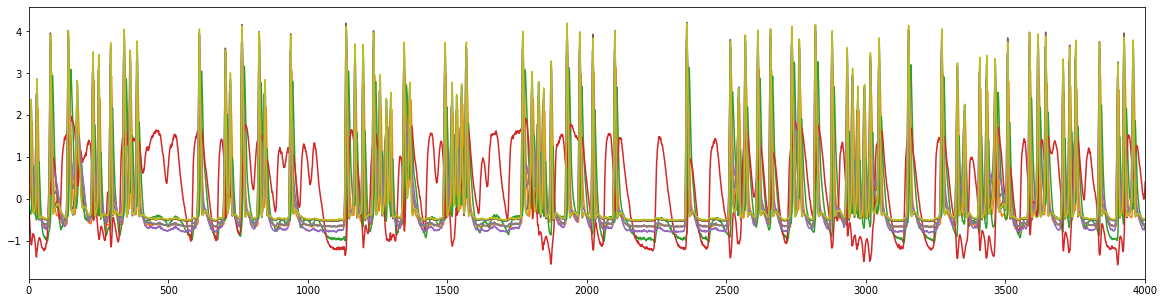

In [10]:
plt.figure(figsize=(20,5))
_ = plt.plot(train_pred)
plt.xlim(0,4000)

In [11]:
def get_drive_indices(drive_name, receptor, training_set, net):
    drive_loc = net.cell_types['L5_pyramidal'].sect_loc[drive_name]
    syn_names = [f'{loc}_{receptor}' for loc in drive_loc]
    syn_indices = np.where(np.in1d(training_set.isec_names, syn_names))[0]

    return syn_indices
    


In [18]:
n_L5Pyr = 300
n_samples = 2000
input_spikes = np.zeros((n_L5Pyr, n_samples, len(training_set.isec_names)))

prox_indices = get_drive_indices('distal', 'ampa', training_set, net_train)
prox_time_indices = np.random.choice(list(range(n_samples)), size=n_samples // 100, replace=False)
prox_time_indices.sort()

for isec_idx in prox_indices:
    input_spikes[0, prox_time_indices, isec_idx] = 20
    input_spikes[1, prox_time_indices, isec_idx] = 10


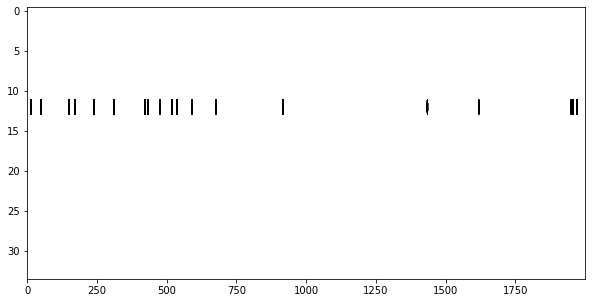

In [19]:
plt.figure(figsize=(10, 5))
plt.imshow(input_spikes[0,:,:].T, aspect='auto', cmap='gray_r', vmin=0, vmax=0.0005)

In [20]:
threshold = 1.0
with torch.no_grad():
    input_spikes_tensor = torch.tensor(input_spikes).float().to(device).requires_grad_(False)

    L5pyr_model.eval()
    pred_y = list()
    cell_spikes = list()
    for time_idx in range(1000):
        batch_x = input_spikes_tensor[:, time_idx:time_idx+100, :]

        out = L5pyr_model(batch_x)
        pred_y.append(out.cpu().detach()[:,-1,:])

        if time_idx > 1:
            cell_spiked = (pred_y[-1][:, -1] > threshold) & (pred_y[-2][:, -1] < threshold)
            cell_spikes.append(cell_spiked)
            # input_spikes_tensor[:, time_idx+100, :] += (weight_matrix * cell_spiked)


    pred_y = torch.stack(pred_y).numpy()
    cell_spikes = torch.stack(cell_spikes).numpy()

: 

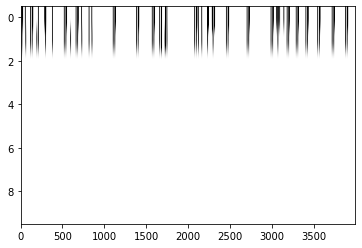

In [64]:
plt.imshow(cell_spikes.T, aspect='auto', cmap='gray_r', vmin=0, vmax=0.1)

In [65]:
(pred_y[-1] - pred_y[-2]).shape

(10, 9)

In [66]:
out.shape

torch.Size([10, 54, 9])

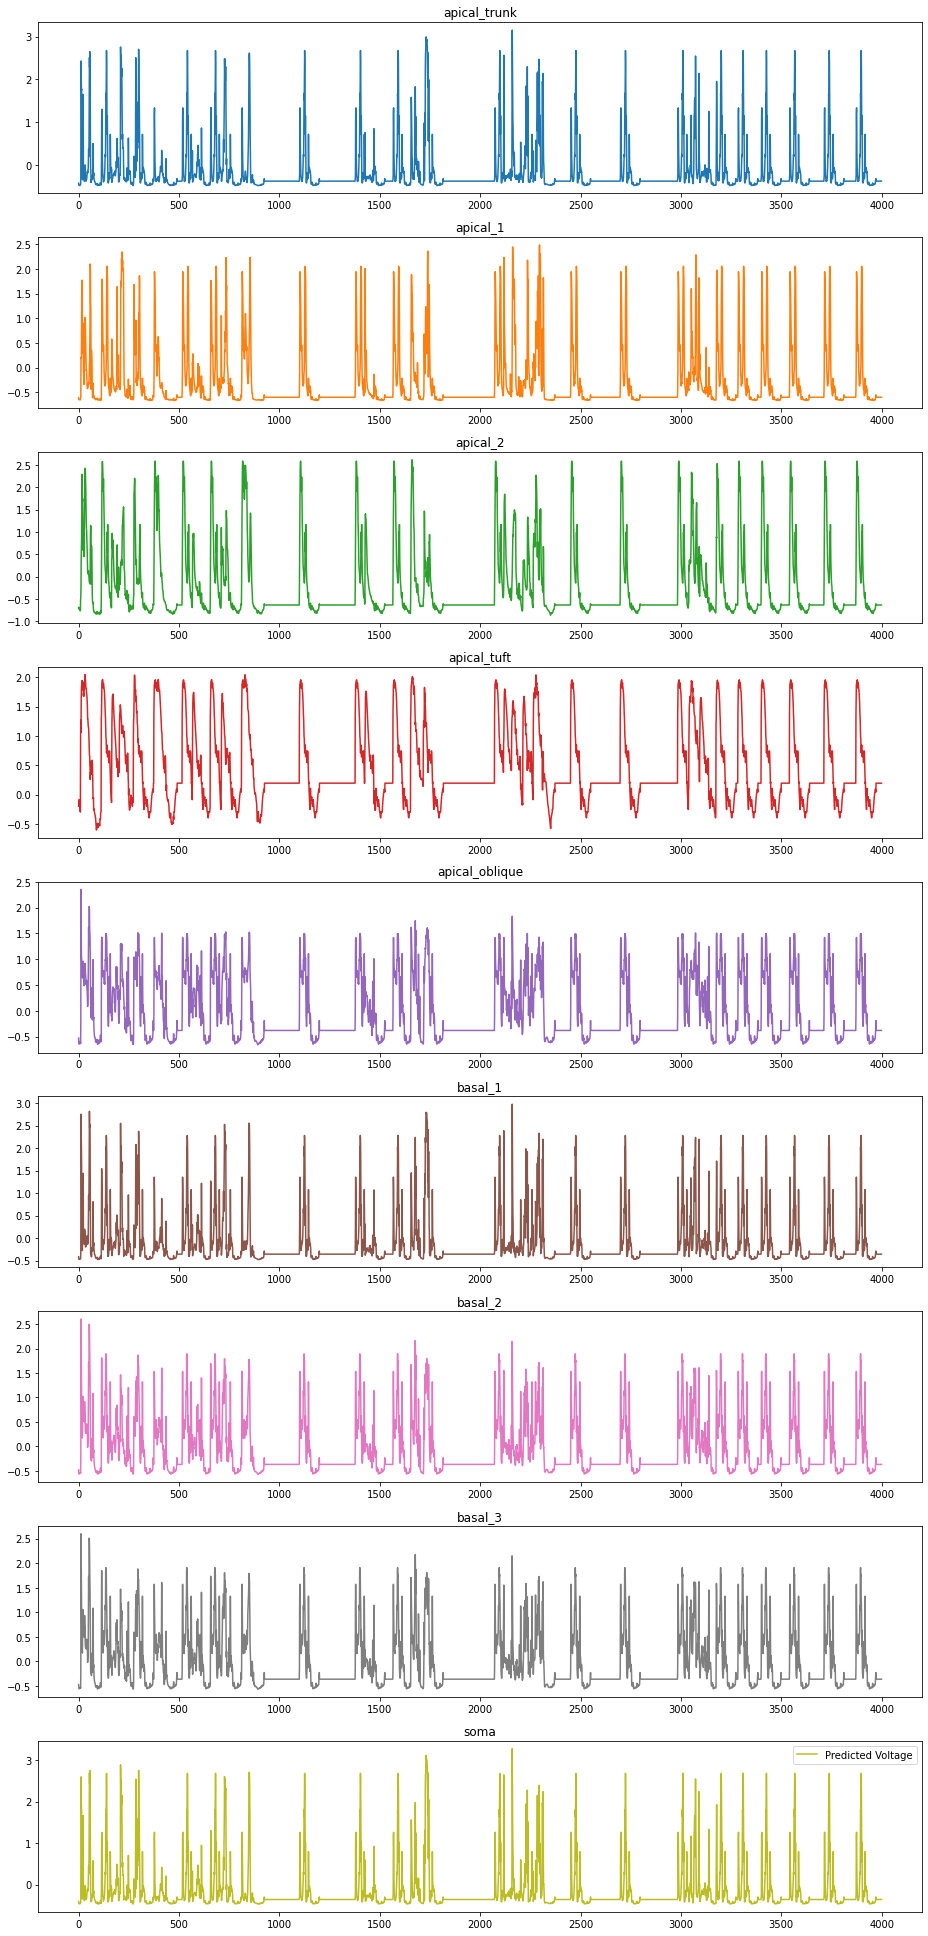

In [67]:
output_size = len(training_set.vsec_names)
plt.figure(figsize=(13, 3 * output_size))

for idx in range(output_size):
    plt.subplot(output_size, 1, idx+1)
    plt.plot(pred_y[:, 0, idx], color=f'C{idx}', label='Predicted Voltage')
    # plt.xlim(2000, 4000)
    plt.title(training_set.vsec_names[idx])
    # plt.ylim(-0.5,1.8)
plt.legend()
plt.tight_layout()

In [ ]:
# L5pyr_model(training_set[:1000][0])

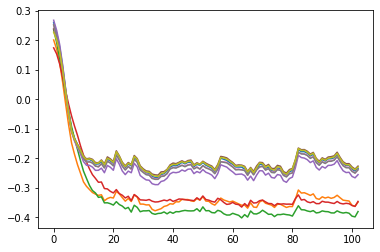

In [ ]:
plt.plot(out1.detach().cpu().numpy()[0,:,:])
